# Начало работы

## Подключение библиотек

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
%matplotlib inline
sns.set(rc={"figure.figsize": (20, 20)})
sns.set_style("whitegrid")

## Функции и переменные

In [2]:

def add_into_list(list_el, new_el):
    """
    Функция добавления списка элементов в массив
    """
    if np.isin(new_el, list_el).sum() == 0:
        return np.append(list_el, new_el)
    else:
        return list_el
    


def del_from_list(list_el, new_el):
    """
    Функция удаления элементов из массива
    """
    if np.isin(new_el, list_el).sum():
        return np.setdiff1d(list_el, new_el)
    else:
        return list_el
    
def exp(y: np.ndarray) -> np.ndarray:
    """
    Потенционирование (обратное логарифмирование) 
    """
    return np.exp(y) - 1
    
RANDOM_STATE = 100
SPLIT_TEST_SIZE = 0.2 # размер тестовой выборки
NUM_SPLIT_FOR_GRID = 5 #на сколько частей будет разбиваться выборка при подборе параметров
TRESHOLD_FOR_CORR = 0.1 #порог значения корреляции, ниже которого будем отбрасывать признаки
TRESHOLD_FOR_HIGH_CORR = 0.7 #при этом пороге корреляции будем тщательнее исследовать на предмет выбросов
TRESHOLD_FOR_HIGH_CORR_BETWEEN_FEATURE = 0.8 #если корреляция выше - удаляемм один из коррелируемых признаков 

## Загрузка данных

In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
#запомним id тестовой - он нужен для загрузки в kaggle, но при анализе удалится ввиду неинформативности для модели 
test_id = test.Id
test_id.head()


0    1461
1    1462
2    1463
3    1464
4    1465
Name: Id, dtype: int64

# Основная информация о данных

In [4]:
print(train.shape)
print(test.shape)


(1460, 81)
(1459, 80)


т.к. объектов меньше 10000, лучше не прибегать к сложным моделям типа бустинга 

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

видим большое кол-во пропущенных значений в колонках Alley,FireplaceQu, PoolQC, Fence, MiscFeature. Надо разобраться, сильно ли их значения влияют на целевую переменную, если нет - то удалить. Так же имеются значения с небольшим количеством пропущенных значений - заполнить их. Для начала соединим в один датасет тестовую и тренировоыную выборки

Много признаков object - нужно проанализировать их значения, может какие то из них numeric

# Анализ целевой переменной

In [6]:
train.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Видим, что распределение целевой переменной не нормальное, сильный перекос вправо: очень большая разница между max и 3ьим квантилем

Text(0.5, 0.98, 'Распределение целевой переменной SalePrice')

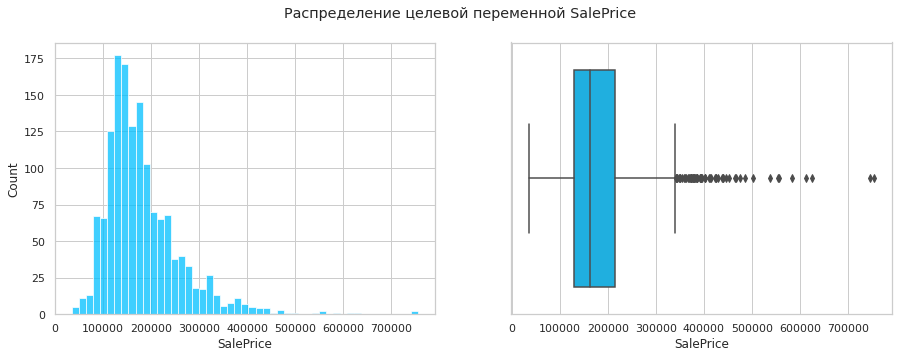

In [7]:
fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sns.histplot(data=train, x='SalePrice', ax=axis[0], color="deepskyblue")
sns.boxplot(data=train, x='SalePrice', ax=axis[1], color="deepskyblue")
plt.suptitle('Распределение целевой переменной SalePrice')

In [8]:
print(stats.shapiro(train.SalePrice))

ShapiroResult(statistic=0.869671642780304, pvalue=3.206247534576162e-33)


По графикам и тесту Шапиро видно, что распределение далеко от нормального, попробуем привести его логарифмированием

In [9]:
train['SalePriceLog'] = np.log(train.SalePrice + 1)
print(stats.shapiro(train.SalePriceLog))

ShapiroResult(statistic=0.9912054538726807, pvalue=1.1467612637261482e-07)


Text(0.5, 0.98, 'Распределение целевой переменной SalePriceLog')

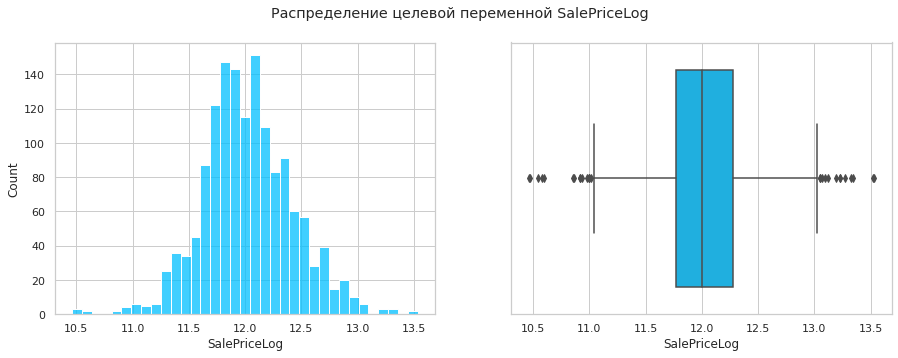

In [10]:
fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sns.histplot(data=train, x='SalePriceLog', ax=axis[0], color="deepskyblue")
sns.boxplot(data=train, x='SalePriceLog', ax=axis[1], color="deepskyblue")
plt.suptitle('Распределение целевой переменной SalePriceLog')

Логарифмирование немного помогло, попробуем еще отсечь выбросы

In [11]:
train_short = train[(train.SalePriceLog<13) & (train.SalePriceLog>11.1)]
#train_short = train_short.drop(columns=['SalePriceLog'], axis=1)
print('train_short shape:', train_short.shape)
print('train_short and train diff rows:', round(100*(train.shape[0]-train_short.shape[0])/train.shape[0],1),'%')

train_short shape: (1428, 82)
train_short and train diff rows: 2.2 %


Процент отброшенных значений не велик (<10%)

In [12]:
print(stats.shapiro(train_short.SalePriceLog))

ShapiroResult(statistic=0.9925791621208191, pvalue=1.3522821973310784e-06)


За счет удаления небольшого числа объектов, еще приблизились к нормальному распределению. На этом закончим обработку целевого признака, построив график окончательного набора данных

/home/sonador/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


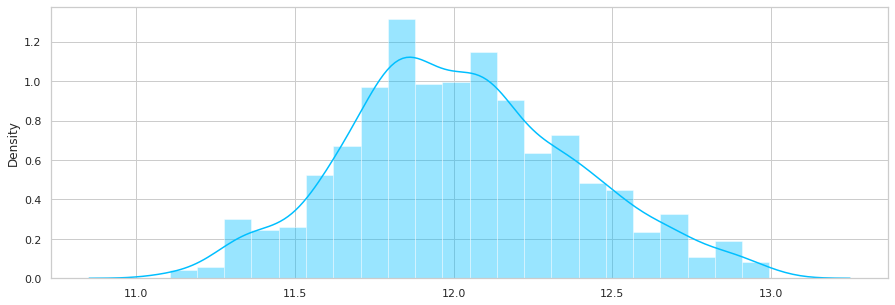

In [13]:
plt.figure(figsize=(15,5))
sns.distplot(x=train_short['SalePriceLog'], color="deepskyblue")
#и перезапишем нашу тренировочную выборку
train = train_short

# Типы данных

In [14]:
#посмотрим какие типы данных в каком количестве
train.dtypes.value_counts()

object     43
int64      35
float64     4
dtype: int64

## Категориальные признаки

In [15]:
#отбор не числовых колонок 
train_non_numeric = train.select_dtypes(exclude=[np.number])
non_numeric_cols = train_non_numeric.columns.values
print(non_numeric_cols)

['MSZoning' 'Street' 'Alley' 'LotShape' 'LandContour' 'Utilities'
 'LotConfig' 'LandSlope' 'Neighborhood' 'Condition1' 'Condition2'
 'BldgType' 'HouseStyle' 'RoofStyle' 'RoofMatl' 'Exterior1st'
 'Exterior2nd' 'MasVnrType' 'ExterQual' 'ExterCond' 'Foundation'
 'BsmtQual' 'BsmtCond' 'BsmtExposure' 'BsmtFinType1' 'BsmtFinType2'
 'Heating' 'HeatingQC' 'CentralAir' 'Electrical' 'KitchenQual'
 'Functional' 'FireplaceQu' 'GarageType' 'GarageFinish' 'GarageQual'
 'GarageCond' 'PavedDrive' 'PoolQC' 'Fence' 'MiscFeature' 'SaleType'
 'SaleCondition']


In [16]:
#должны посмотреть значения категориальных - возможно, ошибка в типе
for col in train_non_numeric:
    print(col, train[col].unique())

MSZoning ['RL' 'RM' 'FV' 'C (all)' 'RH']
Street ['Pave' 'Grvl']
Alley [nan 'Grvl' 'Pave']
LotShape ['Reg' 'IR1' 'IR2' 'IR3']
LandContour ['Lvl' 'Bnk' 'Low' 'HLS']
Utilities ['AllPub' 'NoSeWa']
LotConfig ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
LandSlope ['Gtl' 'Mod' 'Sev']
Neighborhood ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
Condition1 ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
Condition2 ['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']
BldgType ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
HouseStyle ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
RoofStyle ['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat' 'Shed']
RoofMatl ['CompShg' 'WdShngl' 'Metal' 'WdShake' 'Membran' 'Tar&Grv' 'Roll'
 'ClyTile']
Exterior1st ['VinylSd' 'MetalSd'

со значениями все нормально, численных среди категориальных нет

<b>Посмотрим на числовые переменные</b>

## Числовые признаки

In [17]:
# отбор числовых колонок
train_numeric = train.select_dtypes(include=[np.number])
numeric_cols = train_numeric.columns.values
print(numeric_cols)

['Id' 'MSSubClass' 'LotFrontage' 'LotArea' 'OverallQual' 'OverallCond'
 'YearBuilt' 'YearRemodAdd' 'MasVnrArea' 'BsmtFinSF1' 'BsmtFinSF2'
 'BsmtUnfSF' 'TotalBsmtSF' '1stFlrSF' '2ndFlrSF' 'LowQualFinSF'
 'GrLivArea' 'BsmtFullBath' 'BsmtHalfBath' 'FullBath' 'HalfBath'
 'BedroomAbvGr' 'KitchenAbvGr' 'TotRmsAbvGrd' 'Fireplaces' 'GarageYrBlt'
 'GarageCars' 'GarageArea' 'WoodDeckSF' 'OpenPorchSF' 'EnclosedPorch'
 '3SsnPorch' 'ScreenPorch' 'PoolArea' 'MiscVal' 'MoSold' 'YrSold'
 'SalePrice' 'SalePriceLog']


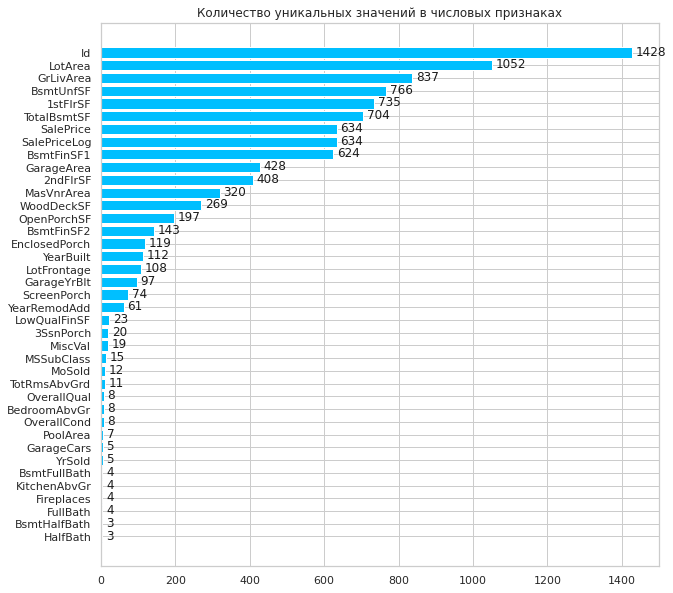

In [18]:
#нужно посмотреть нет ли среди числовых признаков на самом деле категориальных
train_numeric_count = train_numeric.nunique().sort_values()
train_numeric_count 
plt.figure(figsize=(10,10))
plt.barh(y=train_numeric_count.index, width=train_numeric_count.values, color="deepskyblue")
plt.title('Количество уникальных значений в числовых признаках')
for i, v in enumerate(train_numeric_count.values):
    plt.text(v+10, i - .2, str(v), color='k')

по графику видим, что есть некоторые признаки, которые напоминают категориальные, исследуем признаки, у которых уникальных значений <25. Нам нужно изучить что это за столбцы и определить их к категориальным, либо ранговым(в таком случае отнести их к числовым). 

Категориальные: MSSubClass, YrSold, MoSold

Порядковые: BsmtHalfBath, HalfBath, FullBath, BsmtFullBath, Fireplaces, KitchenAbvGr, GarageCars, BedroomAbvGr, PoolArea, OverallCond, OverallQual, TotRmsAbvGrd, 3SsnPorch, MiscVal, LowQualFinSF

## Модификация типов признаков

In [19]:
#изменим тип столбцов у обнаруженных категориальных переменных с int:
new_cat_col = ['MSSubClass', 'YrSold', 'MoSold']
train[new_cat_col] = train[new_cat_col].astype('object')
test[new_cat_col] = test[new_cat_col].astype('object')
#должны добавить их в массивы с категориальными колонками
non_numeric_cols = add_into_list(non_numeric_cols, new_cat_col)

#и удалить из массива с целочисленными столбцами
numeric_cols = del_from_list(numeric_cols, new_cat_col)


# Анализ категориальных переменных

Проверим, как разные значения категориальных признаков с отсутствующими значениями будут влиять на целевую переменную + <b>заменим отсутствующие значения</b>

##  Анализ зависимости целевой переменной


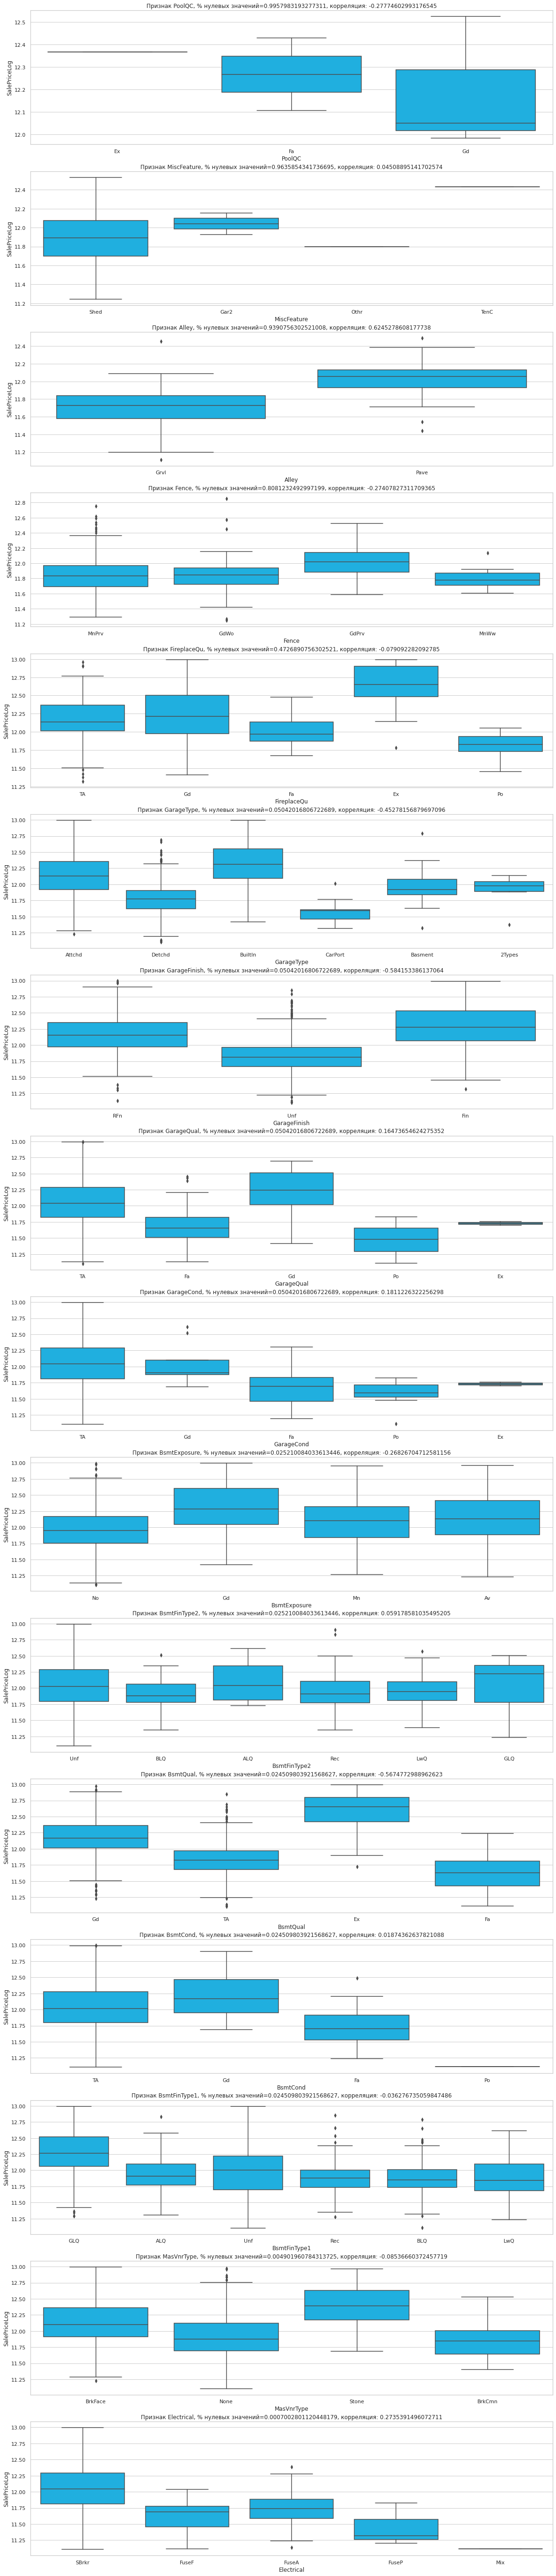

In [20]:
df_col_with_null = pd.DataFrame(columns=['col','corr', 'num_null'])
#получаем все категорифльные перменные, в которых есть пропуски
col_all = train[non_numeric_cols].isna().sum()
col_all = col_all[col_all>0].index.to_list()

#обходим их и строим графики влияния на целевую перменную
for col in col_all:
    corr = train.SalePriceLog.corr(train[col], method='spearman')
    num_null = train[col].isna().sum()
    df_col_with_null.loc[len(df_col_with_null)] = [col, corr, num_null]
    
#теперь построим графики, демонстрирующие зависимость целевой переменной от признака с пустыми значениями
fig,ax = plt.subplots(len(df_col_with_null), figsize=(20,100))
for i, el in enumerate(df_col_with_null.sort_values(by=['num_null'], ascending=False).values):
    sns.boxplot(x=el[0], y='SalePriceLog', data=train, ax=ax[i], color="deepskyblue")
    #print(el[0])
    ax[i].set_title('Признак ' + el[0] + ', % нулевых значений=' + str(el[2]/train.shape[0]) + ', корреляция: ' + str(el[1]))
    


анализ графиков и значений признаков позволил установить следующие выводы:
1. ПРизнаки, в которых лучше отсутствующие заменить на новое знаяение: PolQC, MiscFeature( хоть у них и слабая корреляция - возможно это обусловлено большим количеством отсутствующих значений, но по смысловому значению они могут сильно влиять на стоимость), Alley, Fence, FireplaceQu, GarageType, GarageFinish, GarageQual, GarageCond, BsmtExposure, BsmtQual - у данных признаков nan скорее означает отсутствие того, что обозначено в них

2. Признаки, в которых следуюет отсутствующие значения заменить на моду:  Electrical

3. Признаки, которые следует удалить ввиду слабой информативности: BsmtFinType2, BsmtCond, BsmtFinType1,MasVnrType

Так же следует удалить выбросы ввиду сильного влияния на целевую переменную у признаков: Alley

## Модификация признаков с NaN

In [21]:
#меняем отсутствующие значения на ismissing
col_replace_ismissing = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', \
               'GarageQual', 'GarageCond', 'BsmtExposure', 'BsmtQual']

train[col_replace_ismissing] = train[col_replace_ismissing].fillna('ismissing') 


In [22]:
#меняем отсутствующие значения на моду
col_replace_mode = ['Electrical']
train[col_replace_mode] = train[col_replace_mode].fillna(train[col_replace_mode].mode().iloc[0])

In [23]:
#удаляем слабокоррелируемые признаки
ColForDel = ['BsmtFinType2', 'BsmtCond', 'BsmtFinType1','MasVnrType']

train.drop(columns=ColForDel, axis=1, inplace=True)

#и удалить из массива с категориальными столбцами
non_numeric_cols = del_from_list(non_numeric_cols, ColForDel)

проверим, что во всех категориальных признаках не осталось отсутствующих значений

In [24]:
train[non_numeric_cols].isna().sum()[train[non_numeric_cols].isna().sum()>0]

Series([], dtype: int64)

Ни одного категориального признака с отсутсвующими значениями

Теперь удалим выбросы для признака Alley

## Удаление выбросов у сильноскоррелированных признаков

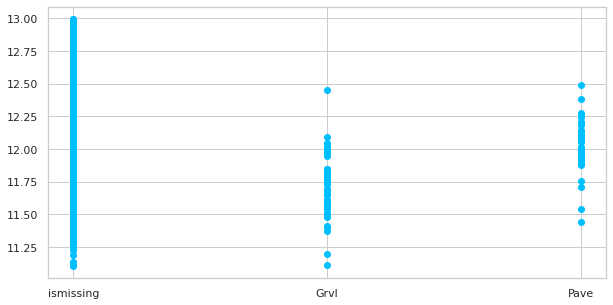

In [25]:
#построим график зависимости целевой от Alley:
plt.figure(figsize=(10,5))
plt.scatter(x=train.Alley, y=train.SalePriceLog, color="deepskyblue")

In [26]:
train = train[((train.Alley == 'Grvl') & ((train.SalePriceLog < 12.25) & (train.SalePriceLog > 11.25))) | \
              (train.Alley == 'ismissing') | ( (train.Alley == 'Pave') & (train.SalePriceLog > 11.60) )]


## Модификация тестовой выборки

In [27]:
test[col_replace_ismissing] = test[col_replace_ismissing].fillna('ismissing') 
test[col_replace_mode] = test[col_replace_mode].fillna(test[col_replace_mode].mode().iloc[0]) 
test.drop(columns=ColForDel, axis=1, inplace=True)

In [28]:
#проверим есть ли еще пропущенные значения в тестовой выборке, в признаках, которые в тренировочной были заполнены
test[non_numeric_cols].isna().sum()[test[non_numeric_cols].isna().sum()>0]

Exterior1st    1
Exterior2nd    1
Functional     2
KitchenQual    1
MSZoning       4
SaleType       1
Utilities      2
dtype: int64

в тестовой оказались еще признаки с пропущенными значениями, обработаем их

In [29]:
test_col_replace_mode = ['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'KitchenQual', 'Functional', 'SaleType']
test[test_col_replace_mode] = test[test_col_replace_mode].fillna(test[test_col_replace_mode].mode().iloc[0])

In [30]:
test[non_numeric_cols].isna().sum()[test[non_numeric_cols].isna().sum()>0]

Series([], dtype: int64)

Мы почистили все недостающие значения в обеих выборках для категориальных переменных

# Анализ числовых переменных

посмотрм на описательные статистики

In [31]:
train.describe()

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,SalePriceLog
count,1423.000000,1166.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1416.000000,1423.000000,1423.000000,...,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000
mean,728.903725,69.919383,10470.629656,6.103303,5.595924,1971.625439,1985.069571,100.852401,440.934645,47.162333,...,473.248067,94.633872,45.807449,21.801827,3.498243,14.425158,2.440618,41.314125,178782.968377,12.027439
std,422.649279,24.066118,9995.811588,1.308260,1.097451,29.848626,20.425607,172.821316,446.895310,162.565719,...,208.565530,124.961874,63.455641,61.209183,29.691069,53.450397,37.966533,493.183096,68561.802592,0.360263
min,1.000000,21.000000,1300.000000,3.000000,2.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,66500.000000,11.104972
25%,360.500000,59.000000,7549.000000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,336.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,130375.000000,11.778177
50%,730.000000,70.000000,9477.000000,6.000000,5.000000,1973.000000,1994.000000,0.000000,385.000000,0.000000,...,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,163500.000000,12.004574
75%,1094.500000,80.000000,11539.500000,7.000000,6.000000,2000.000000,2004.000000,164.000000,710.000000,0.000000,...,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,213000.000000,12.269052
max,1460.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,1418.000000,857.000000,502.000000,552.000000,508.000000,440.000000,738.000000,15500.000000,440000.000000,12.994532


 Видим, что много признаков, у которых много значений 0, найдем их все и выведем % нулевых значений

## Модификация признаков с нулевыми значениями

In [32]:
df_0 = (train[numeric_cols]==0).sum()
df_0[df_0>0]/train.shape[0]*100

2ndFlrSF         56.711174
3SsnPorch        98.313422
BedroomAbvGr      0.421644
BsmtFinSF1       31.623331
BsmtFinSF2       88.404779
BsmtFullBath     58.538299
BsmtHalfBath     94.307800
BsmtUnfSF         8.011244
EnclosedPorch    85.945186
Fireplaces       47.153900
FullBath          0.491918
GarageArea        4.989459
GarageCars        4.989459
HalfBath         62.543921
KitchenAbvGr      0.070274
LowQualFinSF     98.243148
MasVnrArea       58.819396
MiscVal          96.556571
OpenPorchSF      44.905130
PoolArea         99.578356
ScreenPorch      92.199578
TotalBsmtSF       2.459592
WoodDeckSF       51.721715
dtype: float64

<b>Удаление числовых признаков, неинформативных с большим количеством 0</b>

пранализируем переменные, в которых есть 0 значения, при этом слабая корреляция с целевой, чтобы разобраться что означает 0

Всего числовых признаков с нулевыми значениями и слабой корреляцией 7


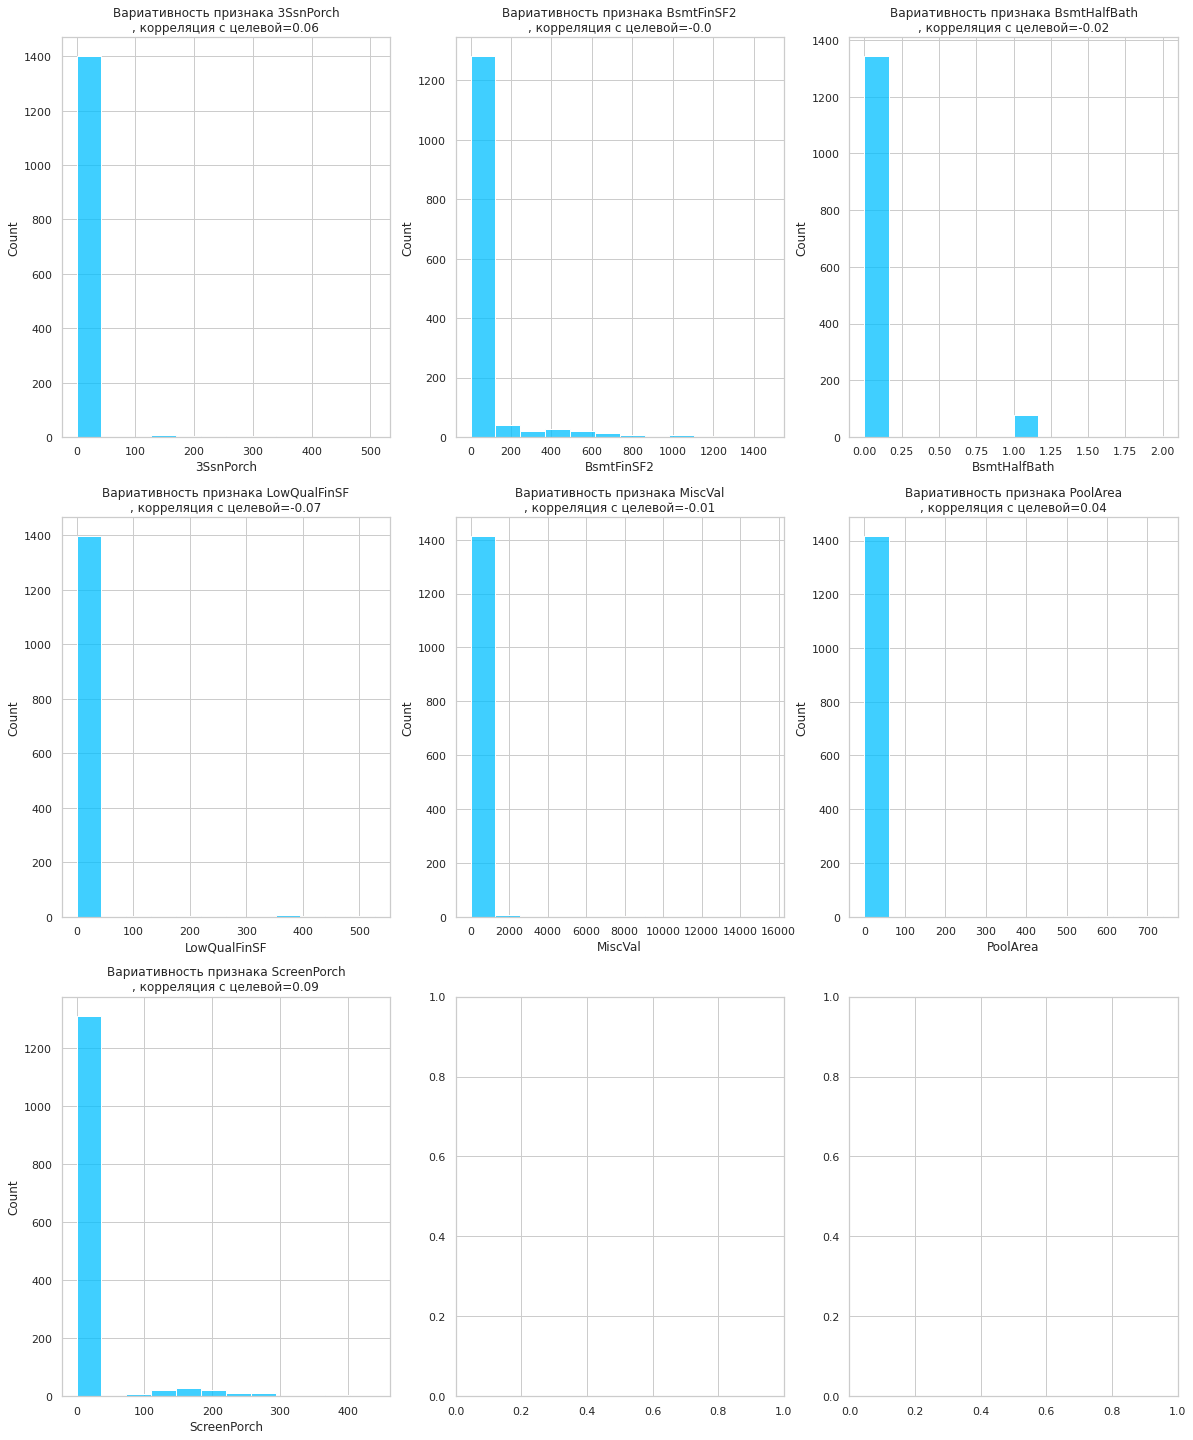

In [33]:

col_int_with_0 = (df_0[df_0>0]/train.shape[0]*100).index
col_int_with_0_low_corr = {}

for col in col_int_with_0:
    corr = train.SalePriceLog.corr(train[col])
    if abs(corr) < TRESHOLD_FOR_CORR:
        col_int_with_0_low_corr[col] = corr
        
fig,axis = plt.subplots(ceil(len(col_int_with_0_low_corr)/3), 3, figsize=(20,25))
y=0

for col, corr in col_int_with_0_low_corr.items():
    i, j = divmod(y, 3)
    sns.histplot(data=train, x=col, ax=axis[i,j], color="deepskyblue")
    axis[i,j].set_title('Вариативность признака ' + col + '\n, корреляция с целевой=' + str(round(corr,2)))
    y += 1

    
print('Всего числовых признаков с нулевыми значениями и слабой корреляцией', len(col_int_with_0_low_corr))

По графикам видим, что почти всегда 0 и при этом это скорее указывает на отсутствующие данные, а не на значения, плюс слабая корреляция с целевой. Все эти признаки малоинформативны и их можно удалить

In [34]:
col_int_for_del = list(col_int_with_0_low_corr.keys())
train.drop(columns=col_int_for_del, axis=1, inplace=True)
test.drop(columns=col_int_for_del, axis=1, inplace=True)

/home/sonador/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [35]:
#так же удаляем из массива с числовыми переменными
numeric_cols = del_from_list(numeric_cols, col_int_for_del)


## Модификация признаков с NaN

In [36]:
col_new_int = train[numeric_cols].isna().sum()
col_int_with_na = col_new_int[col_new_int>0].index.to_list()
col_int_with_na

['GarageYrBlt', 'LotFrontage', 'MasVnrArea']

In [37]:
train[col_int_with_na].isna().sum()

GarageYrBlt     71
LotFrontage    257
MasVnrArea       7
dtype: int64

Построим график процентого соотношения отсутствующих данных в данных колонках

Text(0, 0.5, 'Признак\n')

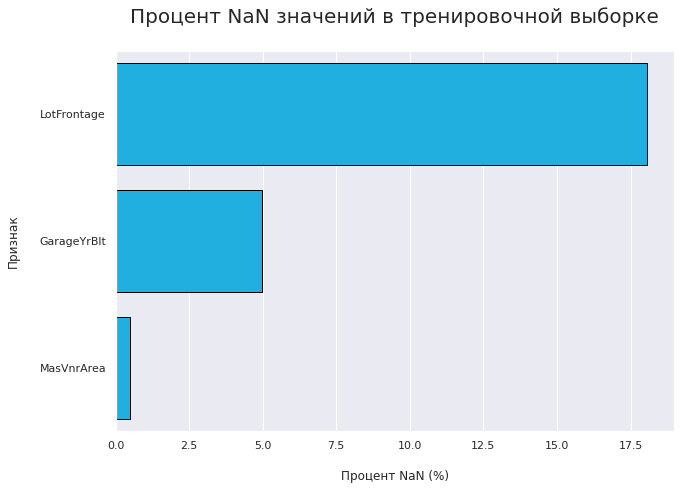

In [38]:
column_name = []
percent_nan = []
for i in col_int_with_na:
    column_name.append(i)
    percent_nan.append(
        round(train[i].isna().sum()*100/len(train[i]), 2))
 
tab = pd.DataFrame({"Column": column_name, "Percent_NaN": percent_nan})
tab.sort_values(by=["Percent_NaN"], ascending=False, inplace=True)


sns.set(rc={"figure.figsize": (10, 7)})
#sns.set_style("whitegrid")

p = sns.barplot(x="Percent_NaN", y="Column", data=tab,
                edgecolor="black", color="deepskyblue")

p.set_title("Процент NaN значений в тренировочной выборке\n", fontsize=20)
p.set_xlabel("\nПроцент NaN (%)")
p.set_ylabel("Признак\n")

Посмотрим графики распределения этих признков, чтоб решить на какое значение заменит

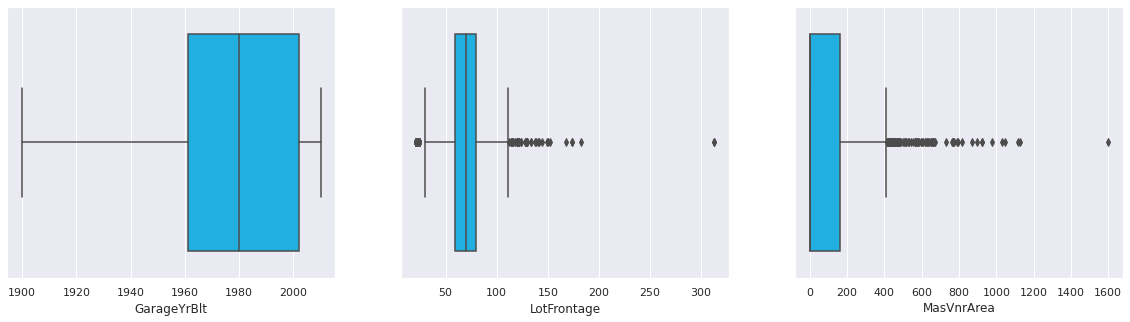

In [39]:
fig,axis = plt.subplots(round(len(col_int_with_na)/3), 3, figsize=(20,5))
for i, col in enumerate(col_int_with_na):
    sns.boxplot(data=train, x=col, ax=axis[i], color="deepskyblue")

Для первого признака возьмем на место отсутствующих среднее, в отстальных - медиану. Первый и третий признаки по хорошему, стоит прологарифмировать, логарифмирование будем делать после корреляционного анализа

In [40]:
train_copy_with_na = pd.DataFrame() 

for col in col_int_with_na:
    train_copy_with_na[col] = train[col]
    if col == 'GarageYrBlt':
        train[col].fillna(train[col].mean(), inplace=True)
    else:
        train[col].fillna(train[col].median(), inplace=True)
   

#my_imputer = SimpleImputer(strategy="median")
#df_train_imputed = pd.DataFrame(my_imputer.fit_transform(train['LotFrontage', 'MasVnrArea']))
#df_train_imputed.columns = train.columns


/home/sonador/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


Мы обработали все пустые значения в тренировочной выборке, проверим:

In [41]:
print('Количество нулевых значений в исходной тренировочной выборке:',train.isna().sum().sum())
print('Количество нулевых значений в копии тренировочной выборки:',train_copy_with_na.isna().sum().sum())

Количество нулевых значений в исходной тренировочной выборке: 0
Количество нулевых значений в копии тренировочной выборки: 335


<b>после замены отстутсвующих значений, проверим распределение измененных признаков и распределение их первоначальных значений</b>

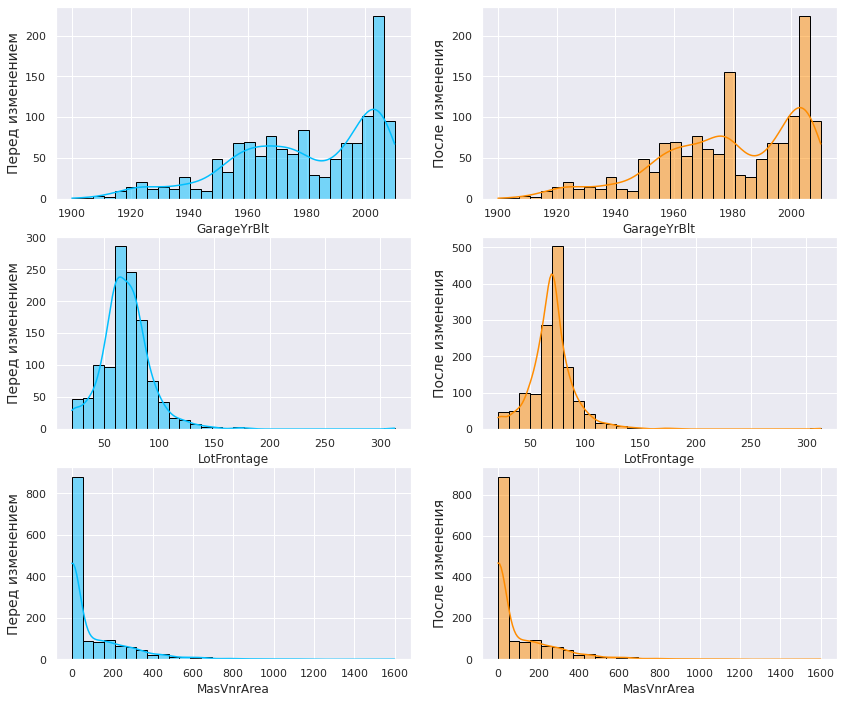

In [42]:
sns.set(rc={"figure.figsize": (14, 12)})
fig, axes = plt.subplots(len(col_int_with_na), 2)
for fig_pos, feature in enumerate(col_int_with_na):

    # до изменений
    p = sns.histplot(ax=axes[fig_pos, 0], x=train_copy_with_na[feature],
                     kde=True, bins=30, color="deepskyblue", edgecolor="black")
    p.set_ylabel(f"Перед изменением", fontsize=14)

    # после изменений
    q = sns.histplot(ax=axes[fig_pos, 1], x=train[feature],
                     kde=True, bins=30, color="darkorange", edgecolor="black")
    q.set_ylabel(f"После изменения", fontsize=14)

Для "LotFrontage" и "GarageYrBlt" распределения изменились после замены. Однако распределение остается прежним для "MasVnrArea". Таким образом, чтобы избежать любой ошибки, связанной с изменениями, сохраняем только признак "MasVnrArea" для своих анализов.

In [43]:
col_int_nan_for_del = ['LotFrontage', 'GarageYrBlt']
train.drop(columns=col_int_nan_for_del, axis=1, inplace=True)
test.drop(columns=col_int_nan_for_del, axis=1, inplace=True)
#так же удаляем из массива с числовыми переменными
numeric_cols = del_from_list(numeric_cols, col_int_nan_for_del)

/home/sonador/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [44]:
numeric_cols

array(['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtFinSF1',
       'BsmtFullBath', 'BsmtUnfSF', 'EnclosedPorch', 'Fireplaces',
       'FullBath', 'GarageArea', 'GarageCars', 'GrLivArea', 'HalfBath',
       'Id', 'KitchenAbvGr', 'LotArea', 'MasVnrArea', 'OpenPorchSF',
       'OverallCond', 'OverallQual', 'SalePrice', 'SalePriceLog',
       'TotRmsAbvGrd', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt',
       'YearRemodAdd'], dtype=object)

## Модификация тестовой выборки

In [45]:
test_with_na = test.isna().sum()
col_test_na = test_with_na[test_with_na>0].index.to_list()
col_test_na

#numeric_cols
#test.MSZoning.value_counts()
#test.MSZoning.isna().sum()

['MasVnrArea',
 'BsmtFinSF1',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'BsmtFullBath',
 'GarageCars',
 'GarageArea']

In [46]:
test.fillna({'MasVnrArea': test.MasVnrArea.median()}, inplace=True)

col_test_na = [x for x in col_test_na if x not in ['MasVnrArea']]
test[col_test_na].isna().sum().sort_values()

BsmtFinSF1      1
BsmtUnfSF       1
TotalBsmtSF     1
GarageCars      1
GarageArea      1
BsmtFullBath    2
dtype: int64

построим графики распределения оставшихся признаков с пустыми значениями

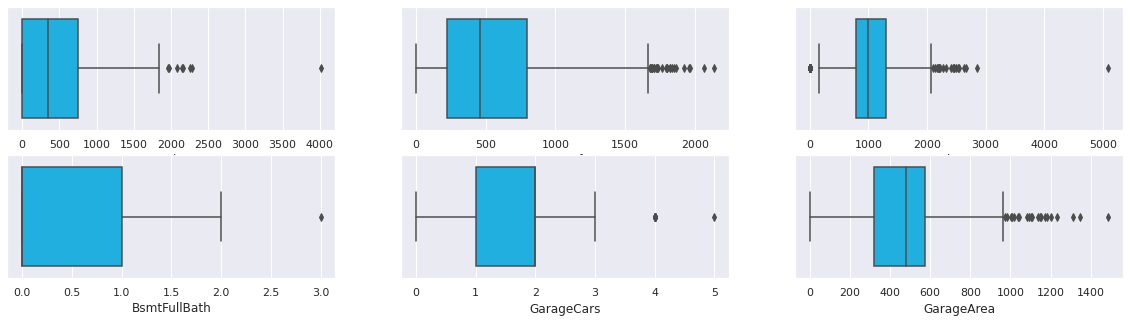

In [47]:
fig,axis = plt.subplots(round(len(col_test_na)/3), 3, figsize=(20,5))
for y, col in enumerate(col_test_na):
    i, j = divmod(y, 3)
    #axis[i].boxplot(test[col])
    sns.boxplot(data=test, x=col, ax=axis[i, j], color="deepskyblue")

во всех переменных есть выбросы, поэтому заменим пропущенные на медиану

In [48]:
test[col_test_na] = test[col_test_na].fillna(test[col_test_na].median().iloc[0]) 

Т.к. изначально пропущенных значений было очень мало, замена не должна была внести сильные изменения в распределение признаков с пропущенными значениями, поэтому проверять по графикам распределения не станем.

Проверим, остались ли пропущенные значения в тестовой выборке

In [49]:
test.isna().sum().sum()

0

<b>Мы обработали все недостающие значения и в тестовой, и в тренировочной выборках</b>

# Корреляционный анализ

## Категориальные признаки и целевая 

перекодируем для начала наши категориальные признаки

In [50]:
train_norm_corr = train[non_numeric_cols].copy('deep')


In [51]:

for i in  non_numeric_cols:
    le = LabelEncoder()
    le.fit(list(train_norm_corr[i].values))
    train_norm_corr[i] = le.transform(list(train_norm_corr[i].values))


In [52]:
#добавим целевой признак
train_norm_corr = train_norm_corr.join(train.SalePriceLog)

Построим график с корреляцией

<AxesSubplot:>

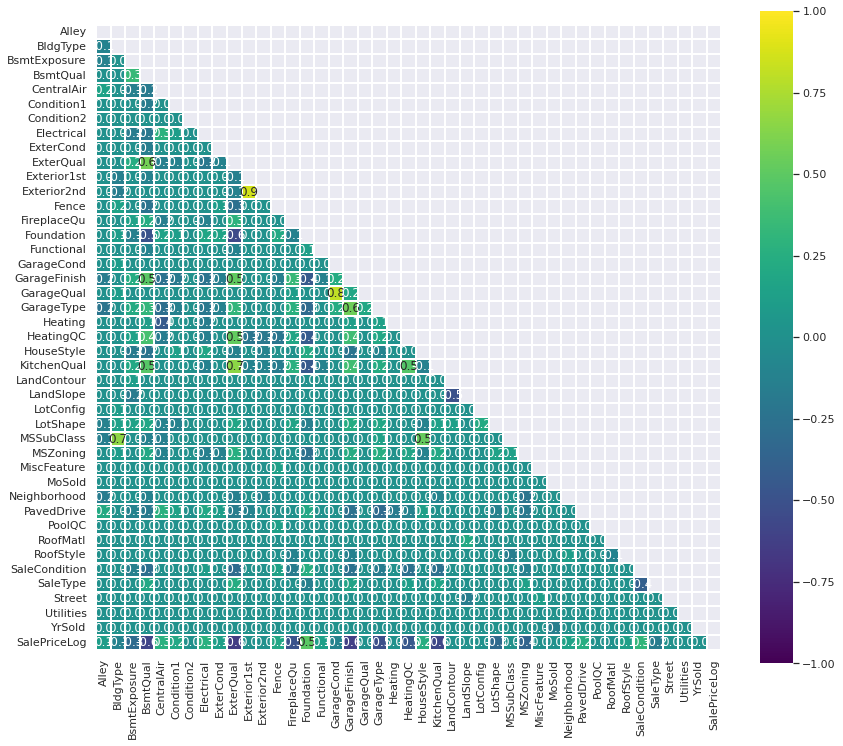

In [53]:
#pd.options.display.float_format = "{:,.1f}".format
corr_matrix = train_norm_corr.corr(method='spearman')
corr_matrix[abs(corr_matrix) <= TRESHOLD_FOR_CORR] = 0
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = "viridis"

#plt.figure(figsize=(20, 20))

sns.heatmap(corr_matrix,  mask=mask, linewidths=0.1, vmax=1.0, vmin=-1.0,  square=True, cmap=cmap, annot=True, fmt=".1f")




#sns.heatmap(train_norm_corr.corr(method='spearman'), annot=True, fmt=".1f");

По графику видим, что у нас есть сильно коррелируемые признаки между собой, соответственно их следует удалить, а так же что есть признаки, не оказывающие сильного влияния на зависимую переменную. Плюс, у нас имеются признаки, которые сильно коррелированы с зависимой перменной, соотв. можно попробовать использовать линейную модель. Начнем с того, что удалим признаки, слабо коррелированные с зависимой переменной

<b>колонки категориальные, которые нужно удалить из за слабой корреляции</b>

In [54]:
col_for_del = []
corr = train_norm_corr[[el for el in train_norm_corr if el != 'SalePriceLog']].corrwith(train_norm_corr.SalePriceLog, method='spearman')
cols_low_corr_target = corr[abs(corr) < TRESHOLD_FOR_CORR].index.to_list()
#колонки с категориальнымит признаками, которые следует удалить ввиду слабой корреляции с целевой
print(cols_low_corr_target)

['Condition2', 'Exterior1st', 'Exterior2nd', 'GarageQual', 'Heating', 'LandContour', 'LandSlope', 'LotConfig', 'MSSubClass', 'MiscFeature', 'MoSold', 'PoolQC', 'RoofMatl', 'Street', 'Utilities', 'YrSold']


<b>колонки категориальные с сильной корреляцией с целевой - надо их изучить на выбросы</b>

In [55]:
cols_high_corr_target = corr[abs(corr)>=(TRESHOLD_FOR_HIGH_CORR-0.1)].index.to_list()
print(cols_high_corr_target)



['ExterQual', 'GarageFinish']


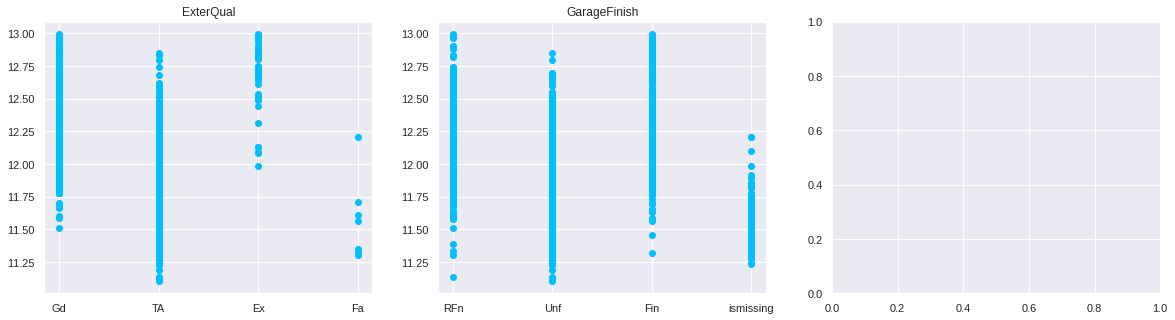

In [56]:
fig,axis = plt.subplots(round(len(cols_high_corr_target)/3), 3, figsize=(20,5))
plt.style.use("seaborn-whitegrid")
for i, col in enumerate(cols_high_corr_target):
    axis[i].scatter(x=train[col], y=train.SalePriceLog, color='deepskyblue')
    axis[i].set_title(col)


Выбросы не значительны - ничего менять не будем


## Числовые признаки и целевая

<AxesSubplot:>

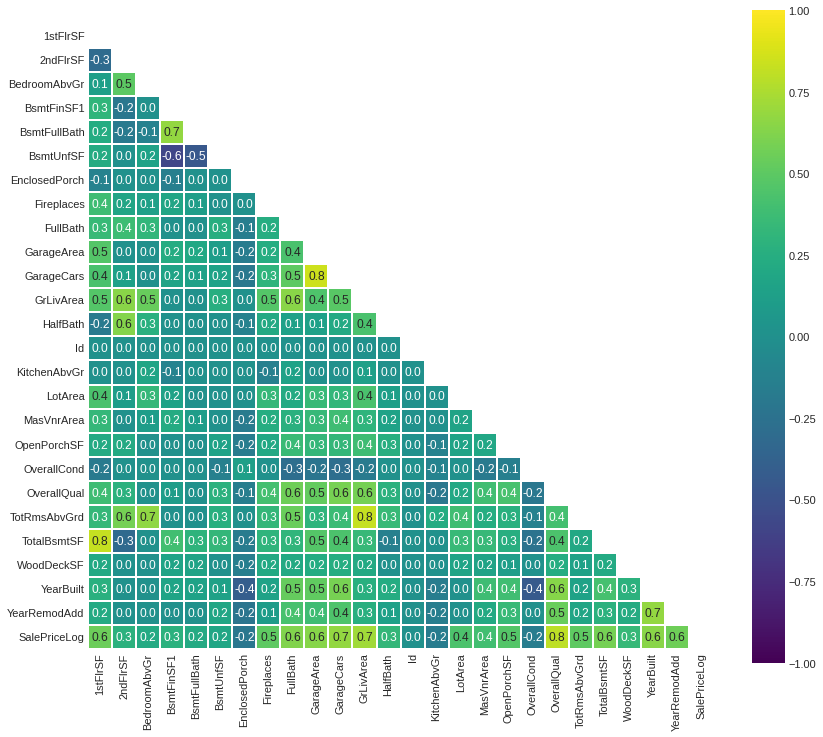

In [57]:
train_num_corr = train[[col for col in numeric_cols if (col!='SalePrice' and col!='SalePriceLog')]]
train_num_corr = train_num_corr.join(train.SalePriceLog) #чтобы целевая была в конце


corr_matrix = train_num_corr.corr(method='spearman')
corr_matrix[abs(corr_matrix) <= TRESHOLD_FOR_CORR] = 0
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = "viridis"


sns.heatmap(corr_matrix,  mask=mask, linewidths=0.1, vmax=1.0, vmin=-1.0,  square=True, cmap=cmap, 
            annot=True, fmt=".1f")




#sns.heatmap(train_num_corr.corr(method='spearman'), annot=True, fmt=".2f");

по графику видим, что у нас есть как плохо коррелируемые признаки числовые, так и хорошо. 

<b>колонки числовые, которые нужно удалить из за слабой корреляции</b>

In [58]:
corr = train_num_corr.corrwith(train_num_corr.SalePriceLog, method='spearman')
cols_low_corr_target_num = corr[abs(corr) < TRESHOLD_FOR_CORR].index.to_list()
#колонки с категориальнымит признаками и числовыми, которые следует удалить ввиду слабой корреляции с целевой
cols_low_corr_target.extend(cols_low_corr_target_num)
print(cols_low_corr_target_num)

['Id']


<b>колонки числовые с сильной корреляцией с целевой - надо их изучить на выбросы</b>

In [59]:
cols_high_corr_target = corr[abs(corr)>=TRESHOLD_FOR_HIGH_CORR].index.to_list()
cols_high_corr_target = [el for el in cols_high_corr_target if el!='SalePriceLog']
print(cols_high_corr_target)

['GrLivArea', 'OverallQual']


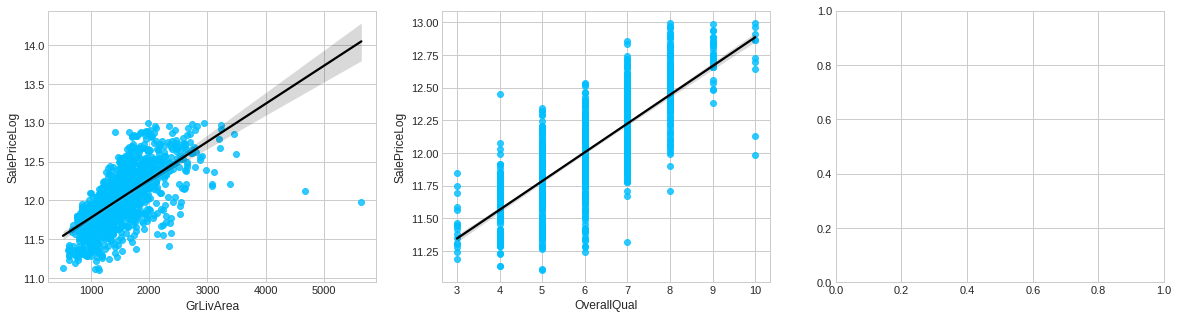

In [60]:

fig,axis = plt.subplots(round(len(cols_high_corr_target)/3), 3, figsize=(20,5))
plt.style.use("seaborn-whitegrid")
for i, col in enumerate(cols_high_corr_target):
    #axis[i].scatter(x=train[col], y=train.SalePriceLog)
    #axis[i].set_title(col)
    sns.regplot(x=train[col], y=train.SalePriceLog, ax=axis[i],  scatter_kws={ "color": "deepskyblue"}, line_kws={"color": "black"})
    


Выбросы есть, особенно у признака GrLivArea - нужно удалить эти значения

In [61]:
train = train[train.GrLivArea < 4000]

## Корреляция между признаками

сначала объединим наши категориальные и числовые признаки


In [62]:
train_norm_cat = train_norm_corr[[col for col in train_norm_corr if col!='SalePriceLog']].join(train_num_corr)
train_norm_cat.head()

,Alley,BldgType,BsmtExposure,BsmtQual,CentralAir,Condition1,Condition2,Electrical,ExterCond,ExterQual,...,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePriceLog
0,2,0,3,2,1,2,2,4,4,2,...,196.0,61,5,7,8,856,0,2003,2003,12.247699
1,2,0,1,2,1,1,2,4,4,3,...,0.0,0,8,6,6,1262,298,1976,1976,12.109016
2,2,0,2,2,1,2,2,4,4,2,...,162.0,42,5,7,6,920,0,2001,2002,12.317171
3,2,0,3,3,1,2,2,4,4,3,...,0.0,35,5,7,7,756,0,1915,1970,11.849405
4,2,0,0,2,1,2,2,4,4,2,...,350.0,84,5,8,9,1145,192,2000,2000,12.429220


In [63]:
#TRESHOLD_FOR_HIGH_CORR_BETWEEN_FEATURE
coll_corr = {}
corr_all = train_norm_cat.loc[:, train_norm_cat.columns != 'SalePriceLog'].corr()
corr_all.loc[:,:] =  np.tril(corr_all, k=-1) 
for col in corr_all.columns:
    
    coll_corr[col] = corr_all[corr_all[col]>TRESHOLD_FOR_HIGH_CORR_BETWEEN_FEATURE].index.to_list()
    
col_for_del = []
for col, col_array in coll_corr.items():
    col_for_del.extend(col_array)
col_for_del = list(set(col_for_del))
col_for_del

['Exterior2nd', 'TotalBsmtSF', 'GarageCars', 'TotRmsAbvGrd']

Эти признаки сильно (> 0.8) коррелированы с другими признаками - исключим их из выборки

In [64]:
cols_low_corr_target.extend(col_for_del)
cols_low_corr_target = list(set(cols_low_corr_target))
print(cols_low_corr_target)

['RoofMatl', 'Id', 'PoolQC', 'TotRmsAbvGrd', 'LandContour', 'Utilities', 'LotConfig', 'MiscFeature', 'MoSold', 'GarageCars', 'YrSold', 'Street', 'Exterior1st', 'Condition2', 'LandSlope', 'Heating', 'Exterior2nd', 'TotalBsmtSF', 'MSSubClass', 'GarageQual']


выше приведены все признаки, которые стоит удалить из-за низкой корреляции с целевой, либо высокой с другими  признаками

<b>удаляем признаки из за корреляции из тренировочной и тестовой выборок</b>

In [65]:
train.drop(columns=cols_low_corr_target, axis=1, inplace=True)
test.drop(columns=cols_low_corr_target, axis=1, inplace=True)

## Окончательный вид выборки

<b>выведем окончательный вид тренировочной выборки, а так же проверим, чтобы форма ее совпадала с тестовой</b>

In [66]:
train.head()

,MSZoning,LotArea,Alley,LotShape,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,...,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,Fence,SaleType,SaleCondition,SalePrice,SalePriceLog
0,RL,8450,ismissing,Reg,CollgCr,Norm,1Fam,2Story,7,5,...,TA,Y,0,61,0,ismissing,WD,Normal,208500,12.247699
1,RL,9600,ismissing,Reg,Veenker,Feedr,1Fam,1Story,6,8,...,TA,Y,298,0,0,ismissing,WD,Normal,181500,12.109016
2,RL,11250,ismissing,IR1,CollgCr,Norm,1Fam,2Story,7,5,...,TA,Y,0,42,0,ismissing,WD,Normal,223500,12.317171
3,RL,9550,ismissing,IR1,Crawfor,Norm,1Fam,2Story,7,5,...,TA,Y,0,35,272,ismissing,WD,Abnorml,140000,11.849405
4,RL,14260,ismissing,IR1,NoRidge,Norm,1Fam,2Story,8,5,...,TA,Y,192,84,0,ismissing,WD,Normal,250000,12.429220


In [67]:
print('форма тренировочной выборки: ', train.shape)
print('форма тестовой выборки: ', test.shape)

форма тренировочной выборки:  (1421, 49)
форма тестовой выборки:  (1459, 47)


# Разделение тренировочной выборки на признаки и целевую переменную

In [68]:
X_train = train.drop(columns=['SalePrice', 'SalePriceLog'], axis=1)
y_train = train['SalePriceLog'].values

X_test = test

In [69]:
print('количество пропущенных значений в тренировочной:', X_train.isna().sum().sum())
print('количество пропущенных значений в тестовой:', test.isna().sum().sum())

количество пропущенных значений в тренировочной: 0
количество пропущенных значений в тестовой: 0


# Нормализуем  числовые признаки

In [70]:
#отбираем числовые признаки
train_numeric = X_train.select_dtypes(include=[np.number])
numeric_cols = train_numeric.columns.values
print(numeric_cols)

['LotArea' 'OverallQual' 'OverallCond' 'YearBuilt' 'YearRemodAdd'
 'MasVnrArea' 'BsmtFinSF1' 'BsmtUnfSF' '1stFlrSF' '2ndFlrSF' 'GrLivArea'
 'BsmtFullBath' 'FullBath' 'HalfBath' 'BedroomAbvGr' 'KitchenAbvGr'
 'Fireplaces' 'GarageArea' 'WoodDeckSF' 'OpenPorchSF' 'EnclosedPorch']


In [71]:
X_train[numeric_cols].head()

,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,1stFlrSF,2ndFlrSF,...,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,Fireplaces,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch
0,8450,7,5,2003,2003,196.0,706,150,856,854,...,1,2,1,3,1,0,548,0,61,0
1,9600,6,8,1976,1976,0.0,978,284,1262,0,...,0,2,0,3,1,1,460,298,0,0
2,11250,7,5,2001,2002,162.0,486,434,920,866,...,1,2,1,3,1,1,608,0,42,0
3,9550,7,5,1915,1970,0.0,216,540,961,756,...,1,1,0,3,1,1,642,0,35,272
4,14260,8,5,2000,2000,350.0,655,490,1145,1053,...,1,2,1,4,1,1,836,192,84,0


In [72]:
sc = StandardScaler()

X_train[numeric_cols] = sc.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = sc.transform(X_test[numeric_cols])
X_train[numeric_cols].head()

,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,1stFlrSF,2ndFlrSF,...,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,Fireplaces,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch
0,-0.198864,0.693710,-0.543693,1.053516,0.879893,0.565870,0.639168,-0.942186,-0.832152,1.195341,...,1.109966,0.811205,1.228413,0.156345,-0.212678,-0.955735,0.366013,-0.756188,0.250259,-0.356593
1,-0.082314,-0.075215,2.189519,0.148349,-0.442687,-0.582285,1.283053,-0.637900,0.296962,-0.801396,...,-0.820587,0.811205,-0.759713,0.156345,-0.212678,0.614322,-0.059438,1.629159,-0.727110,-0.356593
2,0.084910,0.693710,-0.543693,0.986467,0.830908,0.366700,0.118378,-0.297282,-0.654164,1.223399,...,1.109966,0.811205,1.228413,0.156345,-0.212678,0.614322,0.656094,-0.756188,-0.054167,-0.356593
3,-0.087381,0.693710,-0.543693,-1.896660,-0.736593,-0.582285,-0.520773,-0.056578,-0.540140,0.966208,...,1.109966,-1.042046,-0.759713,0.156345,-0.212678,0.614322,0.820473,-0.756188,-0.166324,4.086019
4,0.389967,1.462634,-0.543693,0.952942,0.732939,1.467992,0.518439,-0.170117,-0.028423,1.660623,...,1.109966,0.811205,1.228413,1.397498,-0.212678,0.614322,1.758399,0.780680,0.618775,-0.356593


# Кодируем категориальные признаки

In [73]:
#отбираем категориальные признаки
train_non_numeric = X_train.select_dtypes(exclude=[np.number])
non_numeric_cols = train_non_numeric.columns.values
print(non_numeric_cols)

['MSZoning' 'Alley' 'LotShape' 'Neighborhood' 'Condition1' 'BldgType'
 'HouseStyle' 'RoofStyle' 'ExterQual' 'ExterCond' 'Foundation' 'BsmtQual'
 'BsmtExposure' 'HeatingQC' 'CentralAir' 'Electrical' 'KitchenQual'
 'Functional' 'FireplaceQu' 'GarageType' 'GarageFinish' 'GarageCond'
 'PavedDrive' 'Fence' 'SaleType' 'SaleCondition']


чтобы преобразовать категориальные признаки к дамми-переменным, нужно для начала объединить тренировочную выборку с тестовой, чтоб не получилось так, что в одной одни колонки, в другой - другие. А после уже снова разбить на тренировочную и тестовую

In [74]:
#запоминаем длину тренировочной - чтобы потом ее извлечь из объединенной
len_train = X_train.shape[0]
len_train

1421

In [75]:
#объединяем
X_all = X_train.append(X_test) 
X_all.shape

(2880, 47)

In [76]:
X_all = pd.get_dummies(X_all, columns=non_numeric_cols)
X_all.head()

,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,1stFlrSF,2ndFlrSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,-0.198864,0.693710,-0.543693,1.053516,0.879893,0.565870,0.639168,-0.942186,-0.832152,1.195341,...,0,0,0,1,0,0,0,0,1,0
1,-0.082314,-0.075215,2.189519,0.148349,-0.442687,-0.582285,1.283053,-0.637900,0.296962,-0.801396,...,0,0,0,1,0,0,0,0,1,0
2,0.084910,0.693710,-0.543693,0.986467,0.830908,0.366700,0.118378,-0.297282,-0.654164,1.223399,...,0,0,0,1,0,0,0,0,1,0
3,-0.087381,0.693710,-0.543693,-1.896660,-0.736593,-0.582285,-0.520773,-0.056578,-0.540140,0.966208,...,0,0,0,1,1,0,0,0,0,0
4,0.389967,1.462634,-0.543693,0.952942,0.732939,1.467992,0.518439,-0.170117,-0.028423,1.660623,...,0,0,0,1,0,0,0,0,1,0


In [77]:
#разделяем назад на тренировочную и тестовую выборки
X_train = X_all[:len_train]
X_test = X_all[len_train:]
X_test.head()

,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,1stFlrSF,2ndFlrSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.122612,-0.844140,0.367378,-0.354522,-1.177453,-0.582285,0.075768,-0.669691,-0.720910,-0.801396,...,0,0,0,1,0,0,0,0,1,0
1,0.390677,-0.075215,0.367378,-0.455096,-1.324407,0.050372,1.152856,-0.360864,0.483294,-0.801396,...,0,0,0,1,0,0,0,0,1,0
2,0.346388,-0.844140,-0.543693,0.852368,0.634971,-0.582285,0.840382,-0.971706,-0.631915,0.837612,...,0,0,0,1,0,0,0,0,1,0
3,-0.044004,-0.075215,0.367378,0.885893,0.634971,-0.465127,0.392976,-0.547069,-0.637478,0.783836,...,0,0,0,1,0,0,0,0,1,0
4,-0.548008,1.462634,-0.543693,0.684744,0.341064,-0.582285,-0.409513,1.026589,0.347021,-0.801396,...,0,0,0,1,0,0,0,0,1,0


<b>Мы нормировали числовые признаки, преобразовали категориальные, теперь можно приступать к прогнозированию, но для начала определимся с моделью</b>

# Сравнение простых моделей с параметрами по умолчанию для выбора наилучшей модели

In [78]:
X_train_train, X_train_test, y_train_train, y_train_test = train_test_split(X_train,
                                                    y_train,
                                                    test_size=SPLIT_TEST_SIZE,
                                                    random_state=RANDOM_STATE)

In [79]:
X_train_train.head()

,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,1stFlrSF,2ndFlrSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1255,-0.422843,-0.075215,0.367378,-1.360264,-1.716282,-0.582285,-0.026023,-0.240512,-0.545702,0.152549,...,0,0,0,1,0,0,0,0,1,0
325,-0.548515,-0.844140,0.367378,-1.025017,-1.716282,-0.582285,-0.757496,0.088753,-0.979549,-0.801396,...,0,0,0,1,0,0,0,0,1,0
1029,-0.884990,-0.075215,1.278448,0.014250,-0.638625,1.063795,-0.281683,-0.476674,-1.343869,0.475207,...,0,0,0,1,0,0,0,0,1,0
653,-0.009343,-0.075215,1.278448,-2.198382,0.488017,-0.582285,-1.032094,0.433913,-1.110259,0.865669,...,0,0,0,1,0,0,0,0,1,0
225,-0.884990,-0.844140,-0.543693,-0.019275,-0.687609,0.249541,-1.032094,0.147793,-1.460674,0.769807,...,0,0,0,0,1,0,0,0,0,0


In [81]:
models = [ Ridge(), RandomForestRegressor()]
scores = dict()
for m in models:
    m.fit(X_train_train, y_train_train)
    y_pred = m.predict(X_train_test)
    
    
    print(f'model: {str(m)}')
    print(f'RMSE: {round(np.sqrt(mean_squared_error(exp(y_train_test), exp(y_pred))), 3)}')
    print('-'*30, '\n')

model: Ridge()
RMSE: 21464.47
------------------------------ 

model: RandomForestRegressor()
RMSE: 24293.704
------------------------------ 



Наилучший результат дает Ридж регрессия, поэтому далее юудем работать с ней

# Подбор параметров и предсказание с ипользованием Ридж регрессии

In [82]:
parameters_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100]
}


In [83]:
model = Ridge()

grid_cv = GridSearchCV(model,
                       parameters_grid,
                       cv=NUM_SPLIT_FOR_GRID)
grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100]})

In [84]:
grid_cv.best_score_

0.9160983937078399

In [85]:
grid_cv.best_params_

{'alpha': 10}

In [86]:
parameters_grid = {
    'alpha': [5, 15, 25, 50]
}
model = Ridge()

grid_cv = GridSearchCV(model,
                       parameters_grid,
                       cv=NUM_SPLIT_FOR_GRID)
grid_cv.fit(X_train, y_train)
grid_cv.best_score_

0.9163955867345314

In [87]:
grid_cv.best_params_

{'alpha': 15}

In [88]:
#посмотрим на предсказанные решения тренировочной выборки
pred = grid_cv.predict(X_train)
pd.DataFrame({'log_pred': pred, 'log_real': y_train, 'pred': exp(pred), 'real': train.SalePrice}).head()

,log_pred,log_real,pred,real
0,12.241200,12.247699,207149.302219,208500
1,12.173068,12.109016,193505.905613,181500
2,12.298164,12.317171,219292.088428,223500
3,12.029967,11.849405,167704.868020,140000
4,12.572262,12.429220,288444.772372,250000


<b>выберем за модель Ридж регрессию с alpha=15 и предскажем значения для тестовой выборки</b>

In [89]:
log_predictions = grid_cv.predict(X_test)
predictions = exp(log_predictions).round().astype(int)
predictions[:10]

array([116761, 157334, 178680, 198725, 186852, 173815, 183333, 167710,
       198140, 121276])

In [90]:
submission = {
    'Id': test_id,
    'SalePrice': predictions
}
solution = pd.DataFrame(submission)
solution.to_csv('data/submission.csv',index=False)